In [1]:
!pip install xarray prophet gluonts mxnet h5py mxnet-mkl==1.6.0 numpy==1.23.1

  Obtaining dependency information for xarray from https://files.pythonhosted.org/packages/c3/0a/56eadeb54f258e88f2f31e79fcb84079f8757298f4257d716cbbc674c460/xarray-2023.11.0-py3-none-any.whl.metadata
  Using cached xarray-2023.11.0-py3-none-any.whl.metadata (11 kB)
  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/6b/3c/79d6da1af2a9bd6a534c5a283271eff1bdd673241cda795919a2b41578b3/prophet-1.1.5-py3-none-macosx_10_9_x86_64.whl.metadata
  Using cached prophet-1.1.5-py3-none-macosx_10_9_x86_64.whl.metadata (3.5 kB)
  Obtaining dependency information for gluonts from https://files.pythonhosted.org/packages/20/3d/30ff04c7640094b00c9a79cc4d4d62c40deb43fed49e1a5b162c39a3d229/gluonts-0.14.1-py3-none-any.whl.metadata
  Using cached gluonts-0.14.1-py3-none-any.whl.metadata (9.5 kB)
  Using cached mxnet-1.9.1-py3-none-macosx_10_13_x86_64.whl (39.5 MB)
  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/27/6b/c5ce9d753f

In [5]:
# !pip install plotly==5.9.0

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet
from matplotlib.dates import date2num

from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
import random
from gluonts.model.predictor import Predictor

latitudes = np.flipud(np.arange(65) * 0.25 + 5)
longitudes = np.arange(37) * 0.25 + 97

In [2]:
ds = xr.open_dataset("data/tpw.nc")
df = ds.to_dataframe()
df.reset_index(inplace=True)
df['date'] = df['date'].dt.date
df['lat'] = [latitudes[i] for i in df['lat']]
df['lon'] = [longitudes[i] for i in df['lon']]
df['lat_lon'] = df['lat'].astype(str) + ', ' + df['lon'].astype(str)
df = df.groupby(['date', 'lat_lon'])['tpw'].max().reset_index()
pivoted_df = df.pivot(index=['date'], columns='lat_lon', values='tpw').reset_index()
pivoted_df = pivoted_df.set_index('date')
pivoted_df

lat_lon,"10.0, 100.0","10.0, 100.25","10.0, 100.5","10.0, 100.75","10.0, 101.0","10.0, 101.25","10.0, 101.5","10.0, 101.75","10.0, 102.0","10.0, 102.25",...,"9.75, 97.5","9.75, 97.75","9.75, 98.0","9.75, 98.25","9.75, 98.5","9.75, 98.75","9.75, 99.0","9.75, 99.25","9.75, 99.5","9.75, 99.75"
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,76.800000,78.500000,78.400000,76.800000,76.200000,76.100000,75.900000,75.700000,75.400000,76.400000,...,77.800000,78.300000,78.600000,78.400000,86.100000,98.300000,92.700000,77.500000,77.900000,77.200000
2020-01-02,76.400000,75.600000,76.700000,75.900000,73.800000,74.500000,71.300000,69.400000,69.200000,69.900000,...,76.800000,78.200000,77.600000,81.100000,88.500000,98.500000,95.000000,79.300000,77.200000,75.800000
2020-01-03,74.600000,72.400000,71.800000,72.000000,72.200000,71.600000,71.400000,70.400000,72.100000,74.400000,...,74.200000,74.500000,75.700000,77.000000,87.400000,96.400000,93.700000,77.500000,75.400000,74.600000
2020-01-04,76.400000,76.500000,76.500000,77.600000,77.800000,77.400000,77.400000,78.200000,78.200000,80.900000,...,79.800000,78.300000,76.500000,77.100000,89.900000,98.200000,93.900000,80.100000,80.100000,80.200000
2020-01-05,73.800000,74.700000,76.100000,76.900000,74.900000,72.100000,72.200000,73.700000,78.000000,76.300000,...,78.800000,78.700000,78.700000,79.000000,86.300000,98.400000,93.300000,77.000000,77.200000,75.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,64.780954,64.739354,64.843354,64.990554,65.092954,64.870554,64.385754,63.771354,62.880154,61.750554,...,64.843354,64.444954,64.985754,65.366554,64.336093,61.723354,65.224154,67.006554,66.204893,65.793693
2023-11-18,64.415309,63.860109,62.964109,61.396109,59.404109,58.039309,57.053709,55.949709,54.853709,53.797709,...,61.972449,61.969249,62.929249,63.665249,63.367309,59.792909,63.076109,65.477709,64.840909,63.984909
2023-11-19,46.057265,45.761265,45.127665,44.529265,44.903665,45.601265,45.377265,45.762524,46.458524,46.890524,...,46.158943,46.298143,46.277343,45.598943,44.627743,41.236465,44.113265,46.614065,46.820465,47.146865


In [3]:
training_list = []
for data in pivoted_df:
    training_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 1, 1)].tolist()})

In [4]:
training_data = ListDataset(
    training_list,
    freq="D"
)

In [5]:
entry = next(iter(training_data))
train_series = to_pandas(entry)

In [6]:
test_list = []
for data in pivoted_df:
    test_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 11, 19)].tolist()})

In [7]:
test_data = ListDataset(
    test_list,
    freq="D"
)

In [8]:
entry = next(iter(test_data))
test_series = to_pandas(entry)

In [9]:
index_train_end = pivoted_df.index.get_loc(datetime.date(2023, 1, 1))

In [10]:
index_train_end

1096

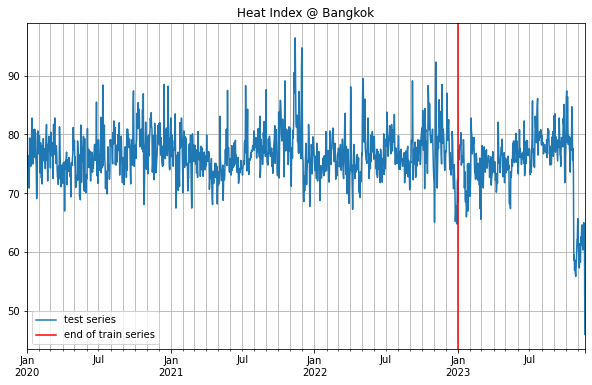

In [11]:
plt.figure(figsize=(10, 6))
test_series.plot(title='Heat Index @ Bangkok')

plt.axvline(pivoted_df.index[index_train_end], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="lower left")
plt.show()

## Select the Model

In [12]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepAREstimator(
    freq="1D",
    prediction_length=306,
    context_length=306,
    num_layers = 5,
    num_cells = 500,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=10,
                    callbacks=callbacks))


# estimator = DeepAREstimator(
#     freq="M",
#     prediction_length=306,
#     context_length=306,
#     num_layers = 2,
#     num_cells = 50,
#     distr_output=StudentTOutput(),
#     dropout_rate=0.01,
#     trainer=Trainer(#ctx = mx.context.gpu(),
#                     epochs=1,
#                     callbacks=callbacks))


In [13]:
predictor = estimator.train(training_data)

100%|██████████| 50/50 [49:30<00:00, 59.42s/it, epoch=10/10, avg_epoch_loss=3.21]


In [15]:


# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("model/gluonts_deepar_tpw/"))


In [14]:

# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("model/gluonts_deepar_tpw/"))

NameError: name 'Path' is not defined

In [32]:
test_data2 = ListDataset(
    random.sample(test_list, 1),
    freq="D"
)

In [33]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data2,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [34]:
forecasts = list(forecast_it)
tss = list(ts_it)

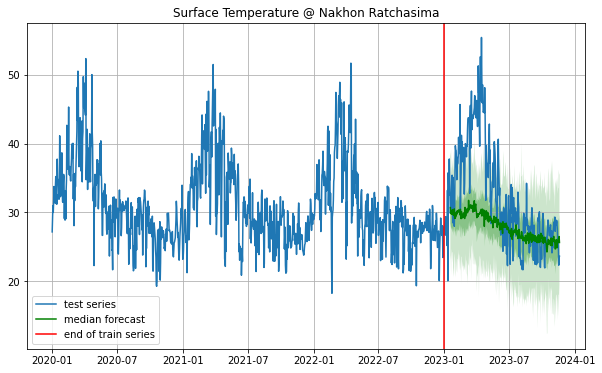

In [37]:
index = 0
ts_entry = tss[index]
forecast_entry = forecasts[index]

plt.figure(figsize=(10, 6))
plt.plot(tss[index].to_timestamp(),label="test series")

# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecast_entry.index.to_timestamp())
forecast_values = np.array(forecast_entry.quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')
for interval in (0.5, 0.9):
    label = interval
    low = (1 - interval) / 2
    plt.fill_between(
        forecast_entry.index.to_timestamp(),
        forecast_entry.quantile(low),
        forecast_entry.quantile(1 - low),
        alpha=0.5 - interval / 3,
        facecolor='g',
        label=None,
    )


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('Surface Temperature @ Nakhon Ratchasima')




plt.show()

In [40]:


# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("model/gluonts_deepar_temp2m/"))


In [42]:
predictor_deserialized

In [43]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data2,  # test dataset
    predictor=predictor_deserialized,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [44]:
forecasts_2 = list(forecast_it)
tss_2 = list(ts_it)

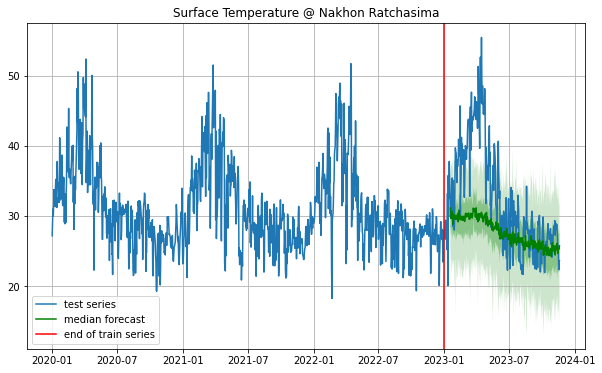

In [45]:
index = 0
ts_entry_2 = tss_2[index]
forecast_entry_2 = forecasts_2[index]

plt.figure(figsize=(10, 6))
plt.plot(ts_entry_2[index].to_timestamp(),label="test series")

# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecast_entry_2.index.to_timestamp())
forecast_values = np.array(forecast_entry_2.quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')
for interval in (0.5, 0.9):
    label = interval
    low = (1 - interval) / 2
    plt.fill_between(
        forecast_entry_2.index.to_timestamp(),
        forecast_entry_2.quantile(low),
        forecast_entry_2.quantile(1 - low),
        alpha=0.5 - interval / 3,
        facecolor='g',
        label=None,
    )


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('Surface Temperature @ Nakhon Ratchasima')




plt.show()